# Machine Reading: Advanced Topics in Word Vectors
## Part II. Word Vectors via Word2Vec (50 mins)

This is a 4-part series of Jupyter notebooks on the topic of word embeddings originally created for a workshop during the Digital Humanities 2018 Conference in Mexico City. Each part is comprised of a mix of theoretical explanations and fill-in-the-blanks activities of increasing difficulty.

Instructors:
- Eun Seo Jo, <a href="mailto:eunseo@stanford.edu">*eunseo@stanford.edu*</a>, Stanford University
- Javier de la Rosa, <a href="mailto:versae@stanford.edu">*versae@stanford.edu*</a>, Stanford University
- Scott Bailey, <a href="mailto:scottbailey@stanford.edu">*scottbailey@stanford.edu*</a>, Stanford University

This unit will focus on Word2Vec as an example of neural net-based approaches of vector encodings, starting with a conceptual overview of the algorithm itself and end with an activity to train participants’ own vectors.

● 0:00 - 0:15 Conceptual explanation of Word2Vec

● 0:15 - 0:30 Word2Vec Visualization and Vectorial Features and Math

● 0:30 - 0:50 [Activity 2] Word2Vec Construction [using Gensim] and Visualization (from part 1) [We provide corpus]

In [1]:
%%capture --no-stderr
import sys
!pip install Cython  # needed to compile fasttext
!pip install -r requirements.txt
!python -m nltk.downloader all
print("All done!", file=sys.stderr)

All done!


In [2]:
import gensim
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

OK, before we go into Word2Vec in practice, let's talk about what it is.

Word2Vec is a neural-network or deep learning based approach of generating word vectors. There are many resources out there that will go into the heavy details of deep learning in general or deep learning for NLP such as Yoav Goldberg's Neural Network Methods in Natural Language Processing (Morgan & Claypool Publishers, 2017). In this unit, we will give you a high level overview -- just enough for you to understand what w2v really means.

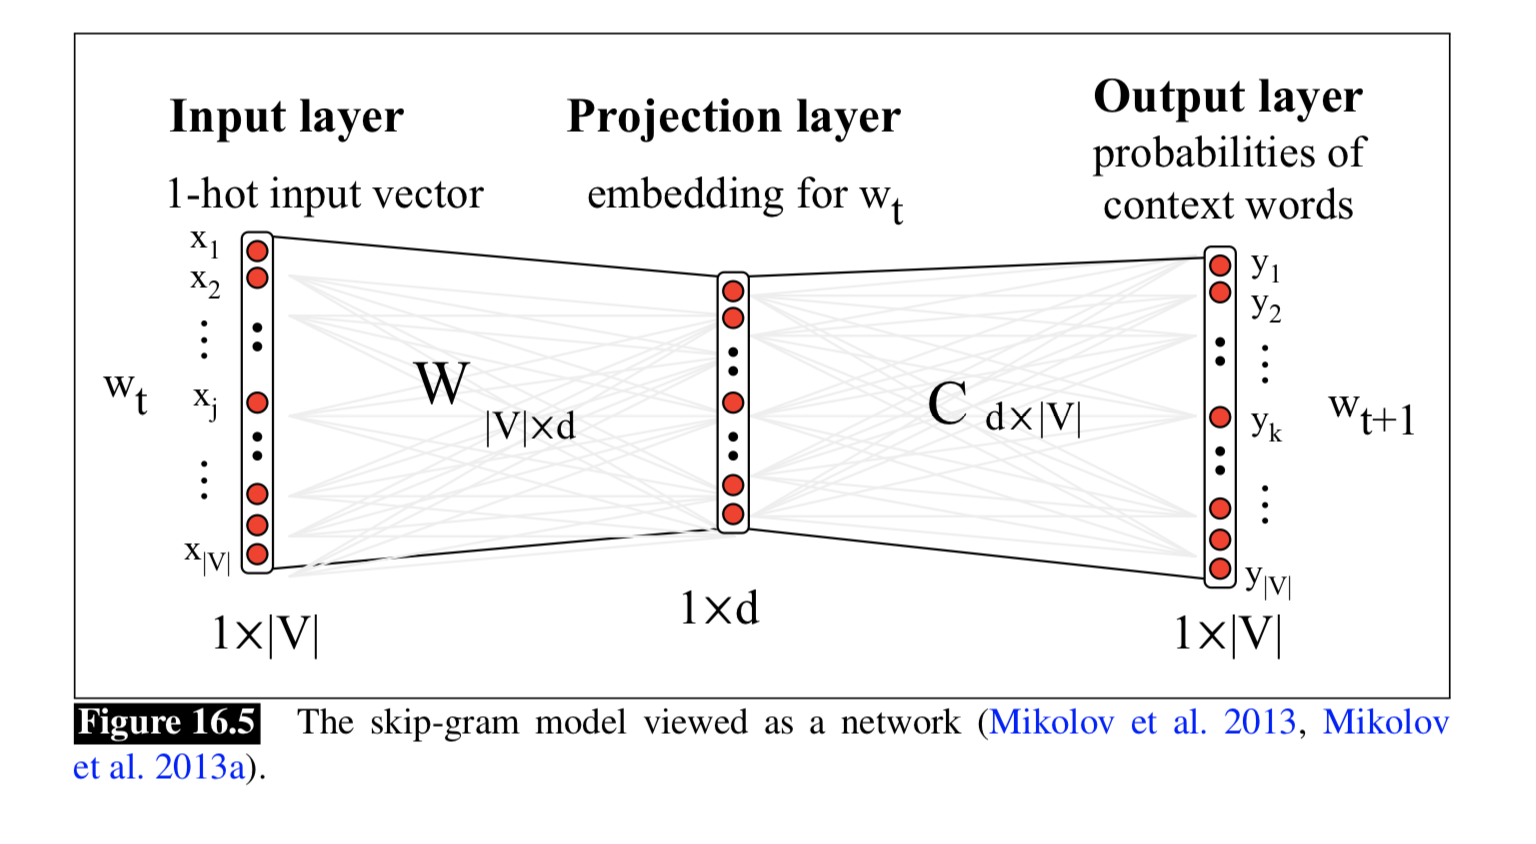

In [3]:
from IPython.display import Image
'''Image from Jurafsky & Martin, Speech and Language Processing, 2016'''
Image("./neuralnet.png")

Neural nets are basically a bunch of weights in the form of matrices. If you have lots of these matrices multiplies in a row, you get layers that make your network 'deep' - hence the name deep learning. Usually if your network has more than one hidden (or projection) layer it's called a 'deep' network. The 'neurons' are just functions that transform your data non-linearly. Each layer of the network will tranform your data so your weights become more sophisticated (and meaningful) with each layer.

What happens in all deep learning tasks is a prediction of some sort. In the case of word2vec, we predict words, given other words. The information for making this prediction is in your weights -- matrices. Based on whether this prediction is correct, the model will calculate the cost and alter your weights, matrices, so that you can do better on the next prediction. This is done iteratively through all of your 'training' data. 

In W2V, your actual predictions are not the end product you want. Remember, we are prediction neighboring or co-occurring words. The actualy performance is just an overall accuracy number. For our pursposes, we take the weights -the coefficients- that allow you to make the best predictions. These become your word vectors. Intuitively, these are the numerical representations that differentiate this word from the other words in the prediction task.

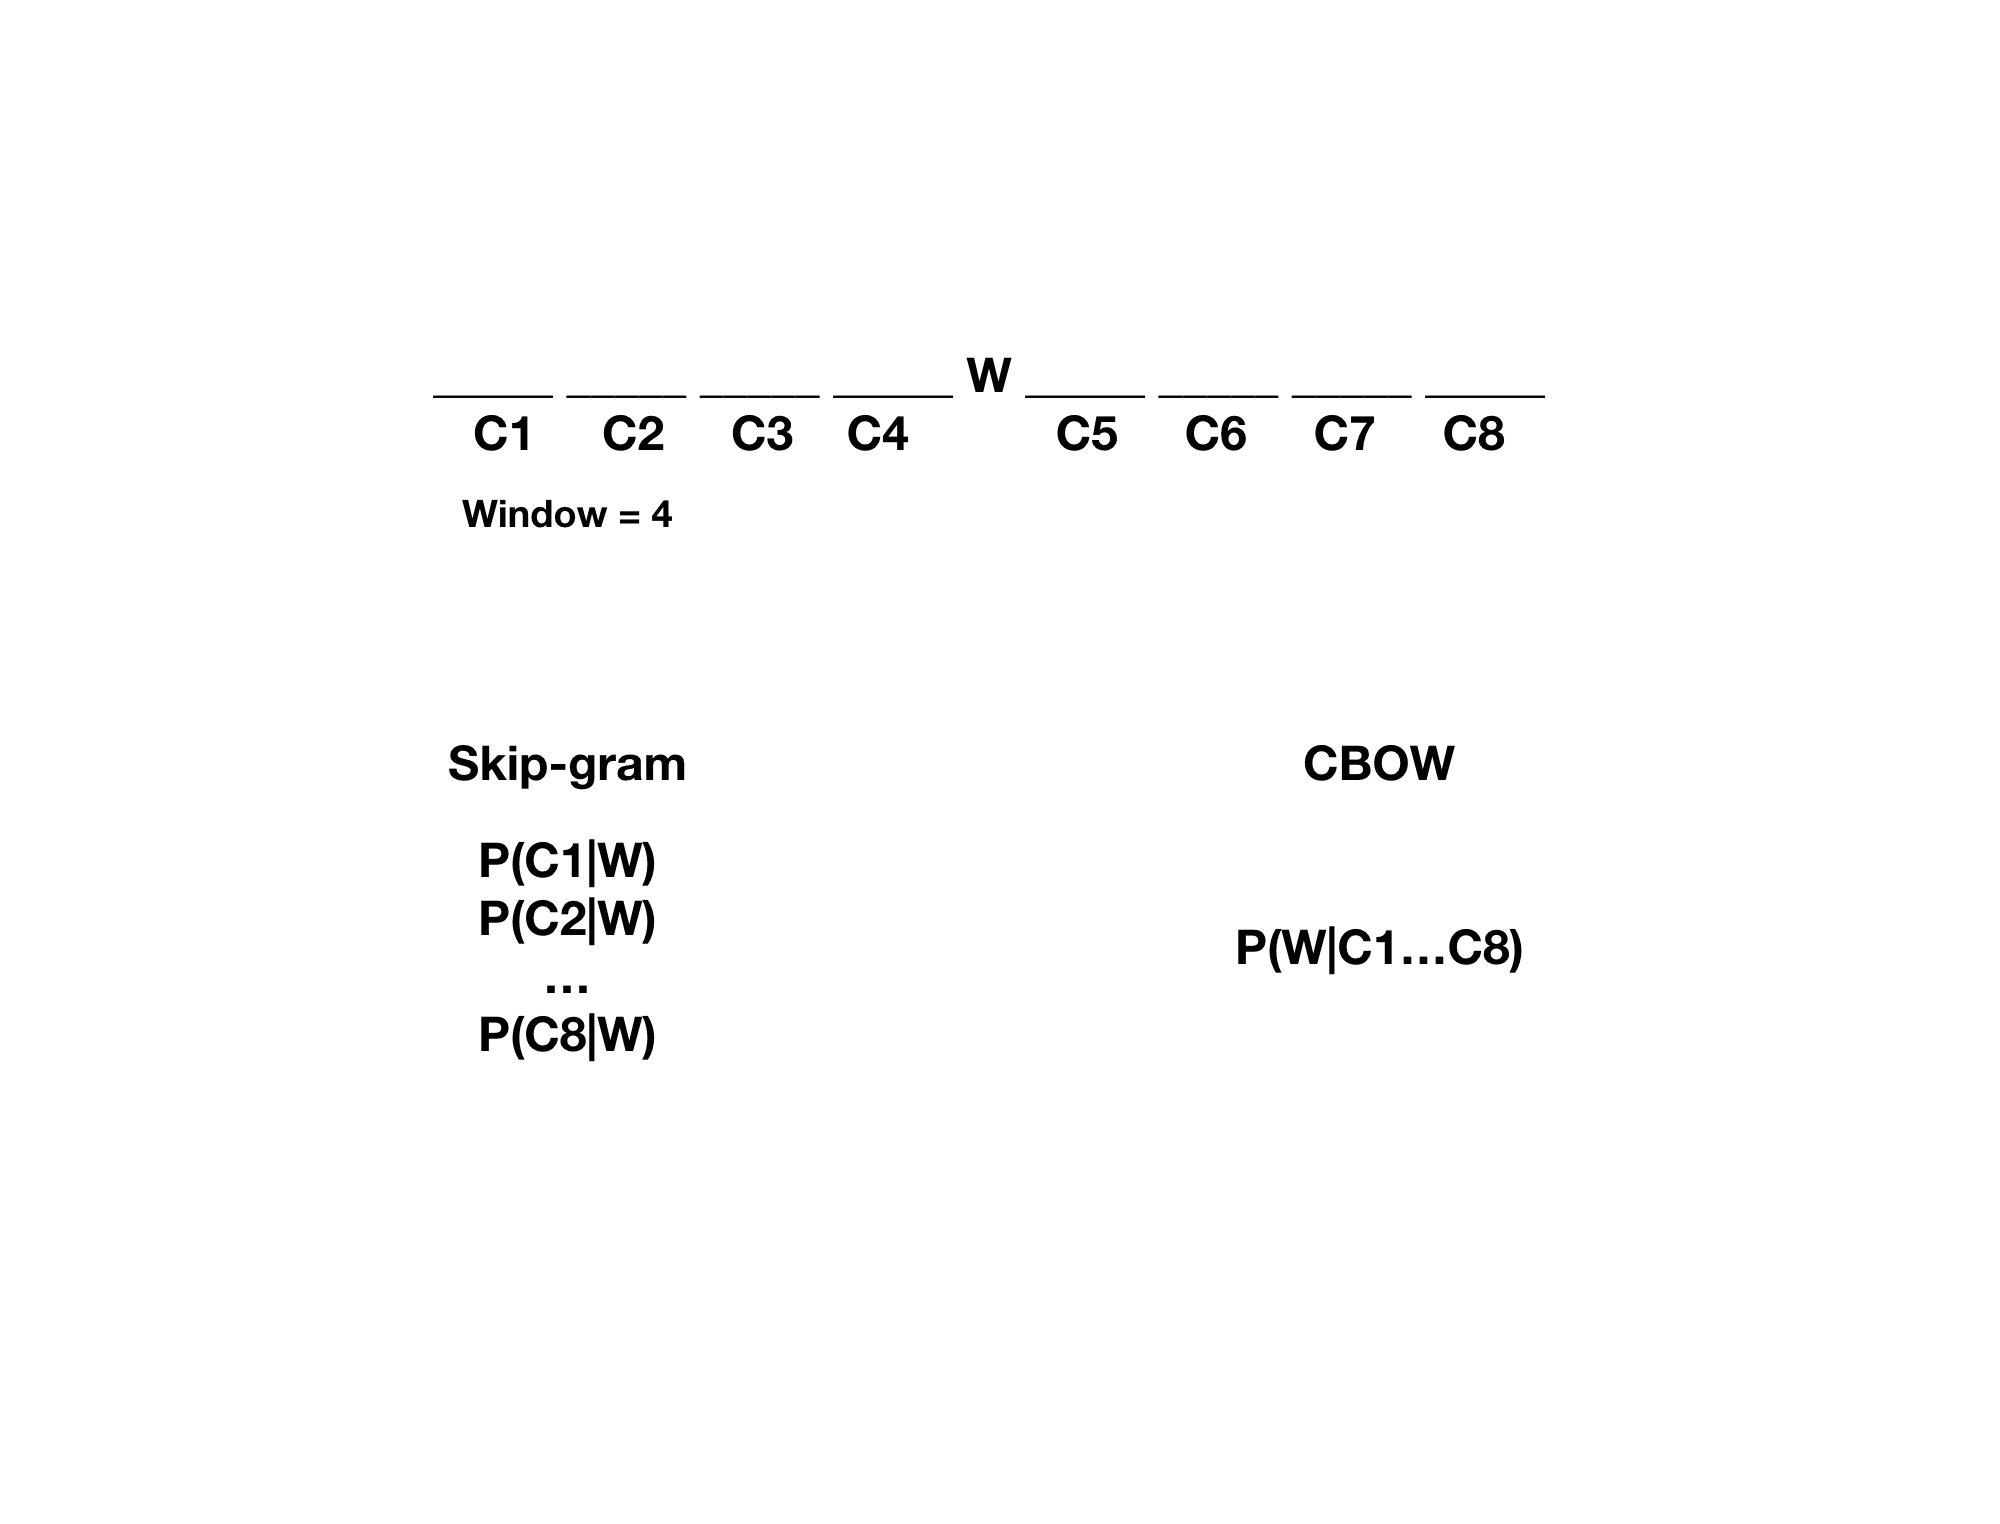

In [4]:
from IPython.display import Image
Image("./cbow_skipgram.png")

The main difference between skip-gram and CBOW, two different methods of w2v, is that while skip gram learns vectors by predicting the context words that come before and after our given word $w$, CBOW predicts the center word $w$ given context words

You may have heard of negative sampling. This is just a short-cut for calculating the denominator needed for the probabilities. Because it turns out to be costly to calculate the denominator exactly everytime, negative sampling approximates the ratio by taking samples of random words from an observed distribution.

In [5]:
### reimporting and reloading materials from part 1
from nltk.corpus import gutenberg

In [6]:
mobydick = gutenberg.raw('melville-moby_dick.txt')
emma = gutenberg.raw('austen-emma.txt')
parents = gutenberg.raw('edgeworth-parents.txt')

In [7]:
corpus = [mobydick, emma, parents]

Let's split our corpus into sentences. 

In [8]:
sentences = sent_tokenize(corpus[0])
sentences

['[Moby Dick by Herman Melville 1851]\r\n\r\n\r\nETYMOLOGY.',
 '(Supplied by a Late Consumptive Usher to a Grammar School)\r\n\r\nThe pale Usher--threadbare in coat, heart, body, and brain; I see him\r\nnow.',
 'He was ever dusting his old lexicons and grammars, with a queer\r\nhandkerchief, mockingly embellished with all the gay flags of all the\r\nknown nations of the world.',
 'He loved to dust his old grammars; it\r\nsomehow mildly reminded him of his mortality.',
 '"While you take in hand to school others, and to teach them by what\r\nname a whale-fish is to be called in our tongue leaving out, through\r\nignorance, the letter H, which almost alone maketh the signification\r\nof the word, you deliver that which is not true."',
 '--HACKLUYT\r\n\r\n"WHALE.',
 '... Sw. and Dan.',
 'HVAL.',
 'This animal is named from roundness\r\nor rolling; for in Dan.',
 'HVALT is arched or vaulted."',
 '--WEBSTER\'S\r\nDICTIONARY\r\n\r\n"WHALE.',
 '...',
 'It is more immediately from the Dut.',
 '

In [9]:
tokenizer = TreebankWordTokenizer()

Let's define a function that a takes a list of texts and converts it for gensim word2vec to use. The function will lower-case text and tokenize by sentence and word.

In [10]:
# sentences = [['hi', 'there'], ['this', 'is', 'a', 'sentence']]

def make_sentences(list_txt):
    all_txt = []
    for txt in list_txt:
        lower_txt = txt.lower()
        sentences = sent_tokenize(lower_txt)
        sentences = [tokenizer.tokenize(sent) for sent in sentences]
        all_txt += sentences
        print(len(sentences))  # let's check how many sentences there are per item
    return all_txt

In [11]:
sentences = make_sentences(corpus)

9822
7489
10054


To train our vectors we call this function below. This function has a couple dozen parameters, some of which are more important than others.
We will explain a few major parameters here. The fields that are MANDATORY are marked with an asterisk:
1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `iter`: This is the number of iterations(entire run) over the corpus, also known as epochs. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Overall, most of these settings wil not concern you unless you are interested in very specific usages of word vectors.

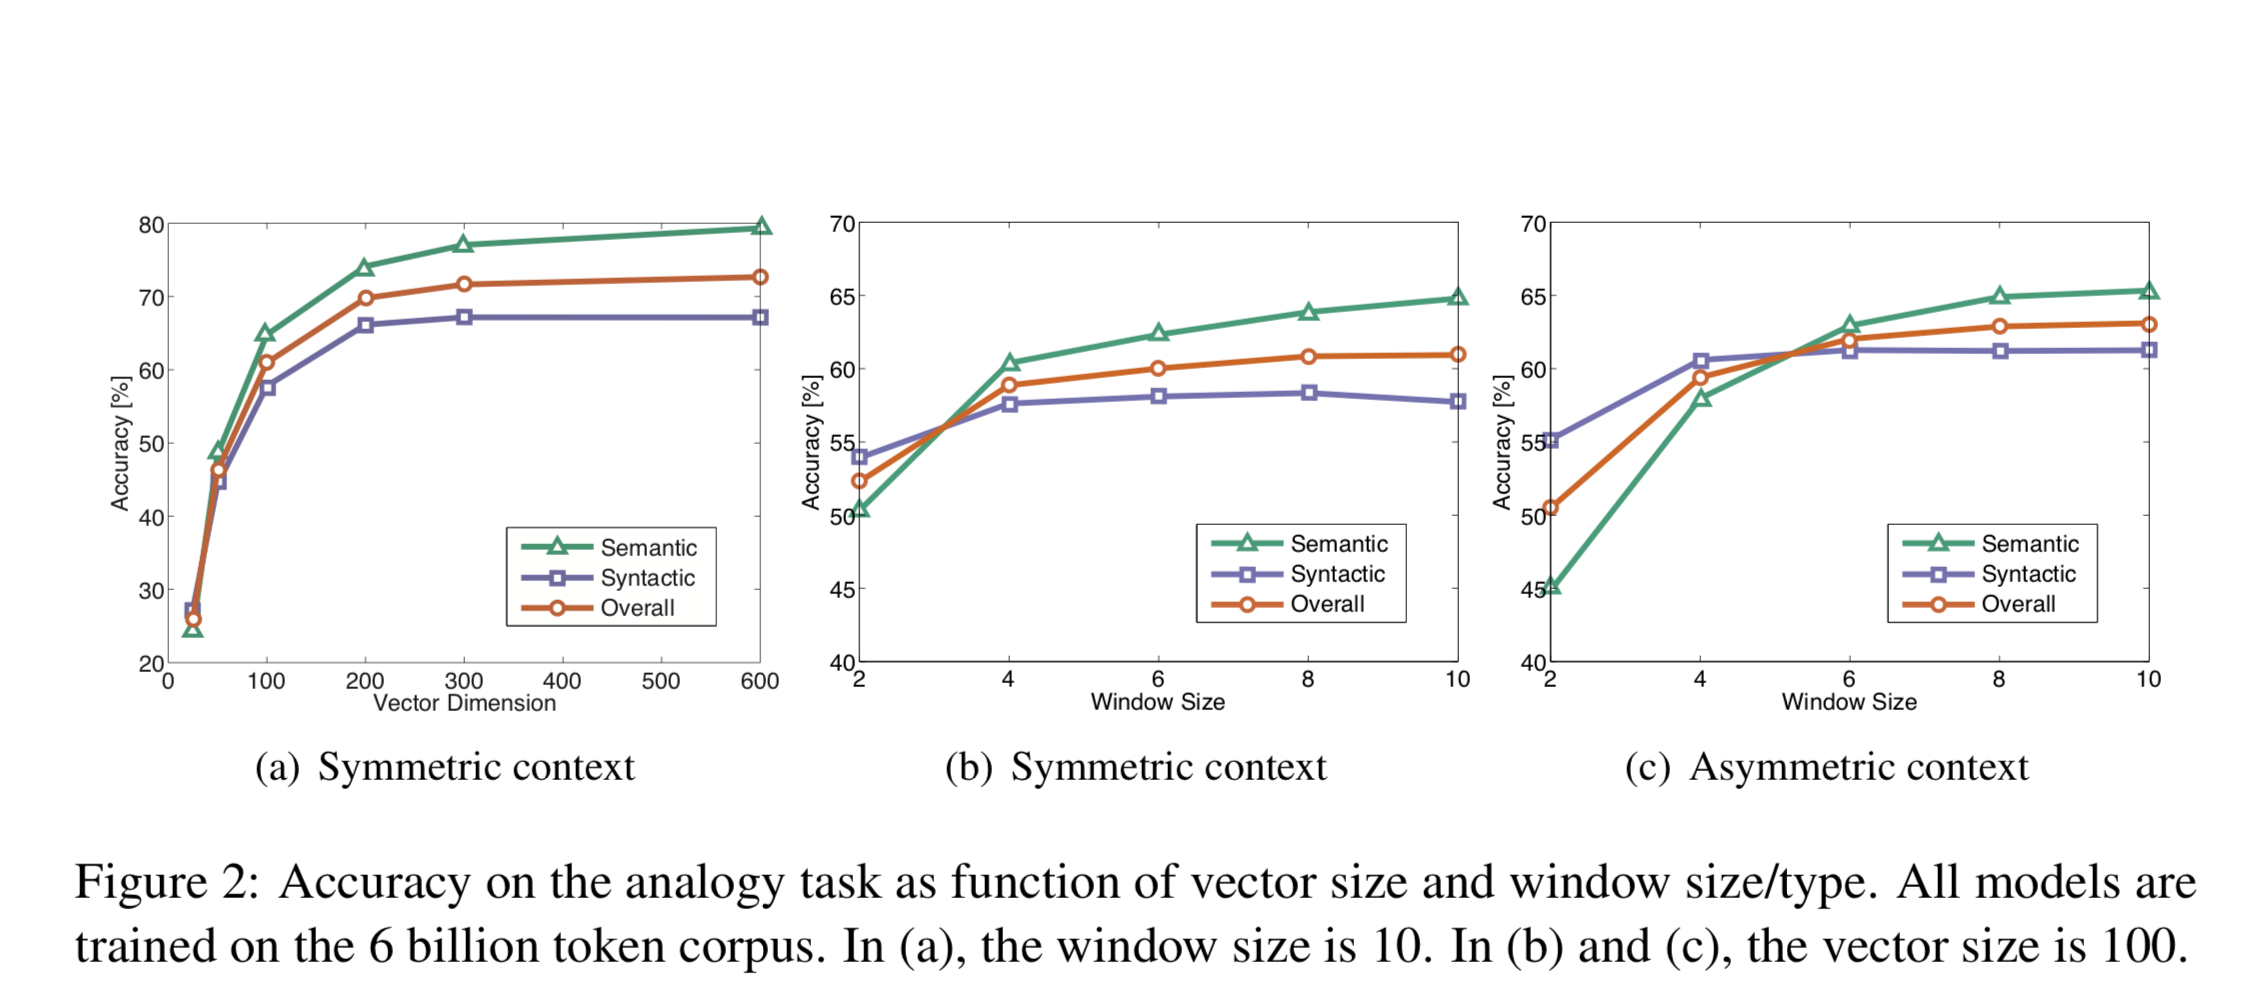

In [12]:
from IPython.display import Image
'''Image from Pennington, et al. 2014'''
Image("./semantic_syntactic.png")

In [13]:
model_example = gensim.models.Word2Vec(sentences, min_count=1, size=100)

Another way of training word2vec vectors with gensim is to use the LineSentence function

In [14]:
# provide the name of the corpus text you want to train on
linesentence_example = gensim.models.word2vec.LineSentence('text8')

In [15]:
model = gensim.models.Word2Vec(linesentence_example, min_count=1, size=100)

In [16]:
model.wv.vocab

{'anarchism': <gensim.models.keyedvectors.Vocab at 0x1a78b2e048>,
 'originated': <gensim.models.keyedvectors.Vocab at 0x1a78b2e080>,
 'as': <gensim.models.keyedvectors.Vocab at 0x1a78b2e0b8>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1a78b2e0f0>,
 'term': <gensim.models.keyedvectors.Vocab at 0x1a78b2e160>,
 'of': <gensim.models.keyedvectors.Vocab at 0x1a78b2e198>,
 'abuse': <gensim.models.keyedvectors.Vocab at 0x1a78b2e1d0>,
 'first': <gensim.models.keyedvectors.Vocab at 0x1a78b2e208>,
 'used': <gensim.models.keyedvectors.Vocab at 0x1a78b2e240>,
 'against': <gensim.models.keyedvectors.Vocab at 0x1a78b2e278>,
 'early': <gensim.models.keyedvectors.Vocab at 0x1a78b2e2b0>,
 'working': <gensim.models.keyedvectors.Vocab at 0x1a78b2e2e8>,
 'class': <gensim.models.keyedvectors.Vocab at 0x1a78b2e320>,
 'radicals': <gensim.models.keyedvectors.Vocab at 0x1a78b2e358>,
 'including': <gensim.models.keyedvectors.Vocab at 0x1a78b2e390>,
 'the': <gensim.models.keyedvectors.Vocab at 0x1a78b2e3c8>,
 '

It's often useful to save your trained model to disk so that you can reload it as needed. 

In [17]:
model.save('our_model')

In [18]:
our_model = gensim.models.Word2Vec.load('our_model') 

In [19]:
model.wv['is']

array([-2.1910827 ,  2.1071856 , -2.61953   , -0.8260924 , -1.4624114 ,
       -0.01870557,  0.04207322, -1.108646  ,  0.50322145, -0.756006  ,
       -1.675038  , -2.7661939 , -3.4975975 ,  2.4925544 ,  3.604652  ,
       -1.0436568 , -2.5286872 , -0.46022934, -0.266707  ,  3.0723722 ,
        1.9968141 , -1.5174078 , -1.9984915 , -0.5603129 , -1.3633065 ,
        1.7471329 , -2.3621716 , -2.9478264 ,  1.7873393 ,  0.6960187 ,
        0.23515041, -2.809697  ,  1.6606531 ,  0.81751996, -0.2423687 ,
       -1.8113445 , -0.3772103 ,  1.6873897 , -0.34249666,  1.2488116 ,
        0.4061612 ,  0.55613995, -0.9603698 ,  3.1870258 , -0.1803773 ,
       -1.7559235 ,  2.8186312 , -5.995415  ,  3.3829803 ,  2.2090712 ,
        2.532697  , -0.6836781 , -0.91056454, -1.301797  ,  1.1076481 ,
       -1.7054887 , -1.7585891 , -0.81957513,  0.9053112 ,  0.89748925,
        2.4992812 , -2.2486284 , -0.40293786,  0.04572542, -0.08886758,
        2.9602556 ,  1.8933096 , -2.3817575 ,  0.56649464, -1.45

In [20]:
model.wv['you']

array([-3.4138255 ,  1.9362178 , -0.0612758 ,  0.07546894, -4.407151  ,
        0.72903633,  1.8129406 , -1.3365406 , -1.7422156 ,  5.556441  ,
        0.6403661 , -0.3569711 ,  2.397139  , -1.0369612 , -0.6978912 ,
       -2.4275725 , -1.1471757 , -0.4620987 , -0.299837  ,  2.5409055 ,
       -1.8869524 ,  0.83673686, -0.75907296, -3.3942099 ,  4.342939  ,
        0.2561983 , -1.3145392 ,  4.0610433 , -2.8039374 ,  0.69377095,
       -0.8724468 , -1.6839938 ,  4.225296  ,  2.5928326 , -0.60826313,
        2.1494644 ,  0.7008469 , -2.9737022 , -2.6246479 , -1.1414808 ,
       -1.0509976 ,  0.15251306, -0.421987  ,  1.7199148 ,  1.2852037 ,
       -2.8995743 , -0.3336396 ,  2.9719315 , -0.4582684 ,  2.3883986 ,
        2.2520993 ,  3.5292232 , -1.6201117 , -1.5913124 , -1.7417569 ,
       -0.87262905, -1.2317363 , -0.30324784,  3.5933757 , -2.1711216 ,
        3.1109443 , -1.667621  , -1.3277173 , -3.5261765 ,  0.27198943,
       -1.9112662 ,  3.9920316 ,  0.56385773,  1.2961733 ,  2.53

Given the size of word2vec models, we'll often load just the vectors into memory, and delete the full model to save RAM. 

In [22]:
my_model = our_model.wv 

In [23]:
del our_model 

In [24]:
print(type(my_model))

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


In [25]:
len(my_model.vocab) #the number of words in our model

253854

Gensim includes corpora and pretrained vectors that we can access and use.

In [26]:
import gensim.downloader as pretrained

Let's see what corpora it has available. 

In [27]:
pretrained.info()['corpora'].keys()

dict_keys(['semeval-2016-2017-task3-subtaskBC', 'semeval-2016-2017-task3-subtaskA-unannotated', 'patent-2017', 'quora-duplicate-questions', 'wiki-english-20171001', 'text8', 'fake-news', '20-newsgroups', '__testing_matrix-synopsis', '__testing_multipart-matrix-synopsis'])

We can also check available pre-trained models.

In [28]:
pretrained.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

We'll work with word2vec trained on Google News. Let's start just with the `text8` corpus. 

In [30]:
pretrained.info('glove-twitter-50')

{'num_records': 1193514,
 'file_size': 209216938,
 'base_dataset': 'Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)',
 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-50/__init__.py',
 'license': 'http://opendatacommons.org/licenses/pddl/',
 'parameters': {'dimension': 50},
 'description': 'Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)',
 'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-50.txt`.',
 'read_more': ['https://nlp.stanford.edu/projects/glove/',
  'https://nlp.stanford.edu/pubs/glove.pdf'],
 'checksum': 'c168f18641f8c8a00fe30984c4799b2b',
 'file_name': 'glove-twitter-50.gz',
 'parts': 1}

In [35]:
news_model = pretrained.load('word2vec-google-news-300')

In [36]:
my_model = news_model.wv
del news_model

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [37]:
my_model['test']

array([-1.42578125e-01, -3.68652344e-02,  1.35742188e-01, -6.20117188e-02,
        7.95898438e-02,  1.90429688e-02, -8.15429688e-02, -1.27929688e-01,
       -2.95410156e-02,  2.36328125e-01, -1.21582031e-01, -2.14843750e-01,
        1.29882812e-01, -2.70996094e-02, -5.20019531e-02,  2.15820312e-01,
       -1.81640625e-01,  5.10253906e-02, -1.60156250e-01, -1.76757812e-01,
        1.83105469e-02, -4.12597656e-02, -2.32421875e-01, -1.03149414e-02,
        1.45507812e-01,  5.24902344e-02, -3.96484375e-01, -1.92871094e-02,
        2.51770020e-03, -1.26953125e-02, -4.39453125e-02,  3.07617188e-02,
        9.57031250e-02, -1.75781250e-01,  1.04370117e-02,  1.89453125e-01,
       -2.36328125e-01,  4.37011719e-02,  2.81250000e-01, -2.07519531e-02,
       -1.81640625e-01, -2.17773438e-01,  2.33398438e-01,  5.29785156e-02,
       -1.13769531e-01,  9.39941406e-03, -1.49414062e-01,  1.99218750e-01,
       -1.75781250e-01,  3.16406250e-01,  8.10546875e-02, -6.12792969e-02,
       -1.52343750e-01, -

Given these vectors, let's explore some similarity tasks. 

In [38]:
my_model.similarity('beautiful','sublime')  # Using Cosine-similarity

0.44833773461372856

What do you think will be the similarity measure between 'sublime' and 'sublime'?

In [39]:
my_model.similarity('sublime','sublime')

0.9999999999999999

We're using a similarity measure included in Gensim here, but we could use specific similarity measures from scikit-learn, what you've seen before.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(my_model['beautiful'].reshape(1,-1), my_model['sublime'].reshape(1,-1))

array([[0.44833776]], dtype=float32)

Words that are used in similar contexts should appear closer to each other than those that do not.

In [41]:
print(my_model.similarity('potato', 'leek')) 
print(my_model.similarity('anger', 'potato'))

0.4789269059201001
0.0155280012408357


Gensim gives us a number of handy methods, such as this one that returns a list of most similar words to a given word.

In [42]:
my_model.most_similar('democracy'), my_model.most_similar('liberalism')

KeyboardInterrupt: 

In [43]:
my_model.most_similar('pluralism', topn=20)

[('pluralistic', 0.7280019521713257),
 ('pluralist', 0.7193902730941772),
 ('democracy', 0.6955404281616211),
 ('pluralist_democracy', 0.6928413510322571),
 ('democratic', 0.6840701699256897),
 ('religious_pluralism', 0.6559314131736755),
 ('pluralist_society', 0.6442460417747498),
 ('pluralism_tolerance', 0.631464421749115),
 ('democratization', 0.6295616030693054),
 ('pluralistic_democracy', 0.6286231279373169),
 ('secularism', 0.6188281774520874),
 ('multireligious_society', 0.6062011122703552),
 ('pluralistic_democratic', 0.603635311126709),
 ('religious_tolerance', 0.6026619076728821),
 ('democratic_polity', 0.5967641472816467),
 ('democratic_ideals', 0.5910589098930359),
 ('pluralistic_society', 0.5879446864128113),
 ('religious_toleration', 0.5857032537460327),
 ('democratic_freedoms', 0.5824508666992188),
 ('illiberal_democracy', 0.5818257331848145)]

Given a list of words, we can identify the most similar word to one we provide.

In [44]:
candidates = ['sweet','sour','bitter','nice']
my_model.most_similar_to_given('blueberry', candidates)

'sweet'

Let's look at the similarity of each word.

In [45]:
for c in candidates:
    print(c, my_model.similarity('blueberry',c))

sweet 0.3033926176016938
sour 0.20343720426644013
bitter 0.18500672031976945
nice 0.07704492863613943


If we want to a list of words that are closer to a given word than some other word of interest, there's an easy method for it. You could read the below as, "words closer to cold than is the word dry".

In [46]:
my_model.words_closer_than('cold','dry')

['winter',
 'warm',
 'temperatures',
 'wet',
 'freezing',
 'warmer',
 'icy',
 'chill',
 'chilly',
 'Cold',
 'windy',
 'colder',
 'snowy',
 'chilled',
 'frigid',
 'humid',
 'coldest',
 'freezing_temperatures',
 'cold_snap',
 'foggy',
 'frosty',
 'shivering',
 'arctic',
 'balmy',
 'wintry',
 'bitterly_cold',
 'frigid_temperatures',
 'toasty',
 'hot_humid',
 'unseasonably_warm',
 'colder_temperatures',
 'bone_chilling',
 'chilly_temperatures',
 'cold_winters',
 'subzero_temperatures',
 'unseasonably_cold',
 'wintery',
 'COLD',
 'unusually_warm',
 'coldest_winter',
 'sub_freezing_temperatures',
 'bone_chilling_cold',
 'Bitter_cold',
 'subzero',
 'arctic_blast',
 'unseasonably_hot',
 'warm_humid',
 'frigid_weather',
 'bone_chilling_temperatures',
 'teeth_chattering',
 'chilliest',
 'toasty_warm',
 'subfreezing',
 'cooler_temps',
 'Sweltering',
 'unseasonable_cold',
 'freezing_temps',
 'frost_bitten',
 'subzero_weather',
 'Brrrr',
 'unseasonably_chilly',
 'warmish',
 'frigid_temps',
 'biting

You can also play with analogy tasks. The commonly seen task is:

'London is to England as Baghdad is to ____?'


' A      is to A\*.     as B      is to  B\*  '
                         
Gensim provides two different ways of implementing this task. You may be more familiar with the the additive version also called the 3CosAdd method:

$$\underset{b*\in V}{\textrm{arg max}} (cos(b*,b) - cos(b*,a) + cos(b*,a*))$$

This reflects the abstraction of Baghdad - London + England. In this maximization, we are searching which word vector will allow us to produce the highest value in this equation.

The second is a more balanced approach proposed by Levy & Goldberg 2014 (http://www.aclweb.org/anthology/W14-1618)

We find B* by going through all of the possible B* in the set of vocabulary (V) and identifying which returns the highest value. In other words, finding the argument that maximizes the following equation where the epsilon is added only to avoid division by zero. This is also called the 3CosMul method:

$$\underset{b*\in V}{\textrm{arg max}} \frac{cos(b*,b)cos(b*,a*)}{cos(b*,a)+\epsilon}$$



We can implement this method with a provided function. Positive here refers to words that give the positive contribution to similarity (nominator), and negative refers to words that contribute negatively (denominatory). Here's the additive method.

In [47]:
my_model.most_similar(positive=['woman','king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.549946129322052),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]

Here's the multiplicative method. 

In [48]:
my_model.most_similar_cosmul(positive=['england','baghdad'], negative=['london'])
#This is not correct! Why?

[('afganistan', 0.8269765973091125),
 ('afghanistan', 0.8165150284767151),
 ('iraqis', 0.8074595332145691),
 ('iraqi', 0.7976524829864502),
 ('taliban', 0.7952468395233154),
 ('al_queda', 0.7876250147819519),
 ('iraq', 0.7850340008735657),
 ('gadhafi', 0.7798774838447571),
 ('sri_lanka', 0.778986394405365),
 ('al_qaida', 0.7776364088058472)]

Unfortunately in this example we see that this returns Afganistan (when Baghdad is the capital of Iraq!). This is an example of how the corpus can bias our findings.

We know enough to start asking some questions. What are good vectors? What are bad vectors? How much training/data do we need?

Consider this. What would happen if you retrained your model on the same corpus? Would you get the same vectors?

Gensim has quite a few built-in tools, and it's worth taking some time to see what's available. Check the documentation here: https://radimrehurek.com/gensim/models/keyedvectors.html



If you've been reading about word vectors, you may have heard about GloVe vectors. Gensim can work with those too! Let's take a look at GloVe vectors so that we can understand the difference and see how to use them in Gensim.

How are Glove and W2V different?

GloVe is also a deep learning based approach and trains in similar ways. The main difference is that GloVe predicts the ratios of co-occurrence, such as the elements your saw in the PMI matrix in part 1. GloVe doesn't have a sliding window as does W2V, it constructs a co-occurrence matrix before-hand instead. This is why sometimes GloVe is faster but W2V have be continuously trained with new data whereas GloVe must be trained from scratch everything (construct a new matrix everytime).

In [52]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
glove_file = "./glove/glove.6B.300d.txt"
glove2word2vec_file = "glove2word2vec.txt"
glove2word2vec(glove_file, glove2word2vec_file) #we simply call this function to reformat it a bit
glove_model = KeyedVectors.load_word2vec_format(glove2word2vec_file, binary=False) #read in the same file 

In [53]:
glove_model['test']

array([ 2.6640e-02,  7.3666e-01,  1.4519e-01, -1.2378e+00, -7.8431e-02,
        1.1878e-01,  1.1072e-01, -5.7459e-01, -5.0329e-01, -2.0694e+00,
        5.6273e-01, -6.5392e-02,  2.6165e-01, -2.9559e-01, -1.3630e-01,
        6.6476e-01,  1.1782e-01,  8.5784e-02, -3.1630e-01, -4.7456e-01,
       -3.1628e-01, -6.1258e-01,  1.6968e-01,  2.9080e-01,  1.5166e-02,
        1.9775e-01,  2.6749e-01,  1.0875e-01, -8.6687e-02, -5.8117e-01,
        1.9078e-02, -3.5914e-01, -2.6973e-01, -7.0312e-02, -7.1556e-01,
        1.1675e-01, -5.7603e-01,  2.2745e-01, -5.4766e-01,  1.5907e-01,
        3.0659e-01,  3.1730e-01,  1.1656e-01, -1.0250e-01,  1.1470e-03,
       -2.2274e-01, -5.3550e-01, -4.3364e-01, -2.0306e-01, -3.5997e-01,
        3.5991e-01, -2.0668e-01,  1.4845e-01,  7.7065e-02,  5.2591e-02,
        3.8939e-01,  9.9486e-02, -5.3198e-01, -1.0236e-01,  3.1587e-01,
        2.4825e-01, -3.3952e-01,  8.6676e-02, -3.4517e-01,  4.2221e-01,
        3.3158e-01,  3.3441e-01, -3.4035e-01,  4.9647e-02,  4.55

Given the same test with England and Baghdad from above, let's see how GloVe does. 

In [54]:
glove_model.most_similar_cosmul(positive=['england','baghdad'], negative=['london'])
#Success!

[('iraq', 0.8279445171356201),
 ('fallujah', 0.785504162311554),
 ('iraqi', 0.7701656818389893),
 ('baqouba', 0.7685968279838562),
 ('mosul', 0.7604708671569824),
 ('najaf', 0.7585084438323975),
 ('iraqis', 0.7578032612800598),
 ('marines', 0.7569854259490967),
 ('soldiers', 0.7507175803184509),
 ('samarra', 0.7506063580513)]

### PCA visualizations

Principal Component Analysis is way of analying your data's principal components!
Like SVD from part 1, PCA returns dimensions in order of representing highest variance of your data.

In [55]:
import numpy as np
from sklearn.decomposition import PCA

In [56]:
countries = ["china", "russia", "france", "germany","greece","japan","italy"]

In [57]:
capitals = ["beijing","moscow","paris","berlin","athens","tokyo","rome"]

In [58]:
X = []

for loc in countries+capitals:
    X.append(glove_model[loc])

In [59]:
pca = PCA(n_components=2)
xy_coords = pca.fit_transform(X)
loc_x, loc_y = zip(*xy_coords)

In [60]:
loc_x

(3.980742761872989,
 0.9736519764565262,
 -2.4449608526434177,
 -1.6557736578802633,
 -1.9385075010959951,
 3.496010336738355,
 -3.0224848841528735,
 3.414143978018339,
 0.9186574599425092,
 -1.8621880028925155,
 -1.3593592643011898,
 -1.1887054715845773,
 3.364164038395803,
 -2.6753909168736905)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(loc_x, loc_y)

for _, location in enumerate(countries+capitals):
    ax.annotate(location, (loc_x[_]+.05, loc_y[_]-.05))

plt.title("Countries and their Capitals")
plt.show()